#### Make plots of cloud properties using ISCCP-D and ISCCP-H cloud-top pressure/cloud optical thickness histograms

Cloud properties for CanAM have changed noteably.  These plot will summarize them using matplotlib to generate the graphs and compute the averages.
In this notebook, we compare spatial and zonal means

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as py
from matplotlib.gridspec import GridSpec
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import xesmf as xe
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

Function(s) to compute the weighted mean for a DataArray

In [2]:
def masked_average(xa:xr.DataArray,
                   dim=None,
                   weights:xr.DataArray=None,
                   mask:xr.DataArray=None):
    """
    This function will average
    :param xa: dataArray
    :param dim: dimension or list of dimensions. e.g. 'lat' or ['lat','lon','time']
    :param weights: weights (as xarray)
    :param mask: mask (as xarray), True where values to be masked.
    :return: masked average xarray
    """

    if mask is not None:
        wgt=weight*abs(mask)
        xa_wgt=xa*wgt
        numer=xa_wgt.sum(dim,skipna=True,min_count=1)
        denom=wgt.sum(dim,skipna=True,min_count=1)
        xa_weighted_average=numer/denom
    elif weights is not None:
        wgt=weight
        xa_wgt=xa*wgt
        numer=xa_wgt.sum(dim,skipna=True,min_count=1)
        denom=wgt.sum(dim,skipna=True,min_count=1)
        xa_weighted_average=numer/denom
    else:
        xa_weighted_average =  xa.mean(dim)

    return xa_weighted_average

Function to compute the weighted mean for DataArrays in a DataSet

In [3]:
def masked_average_ds(xs=None,
                      vars=None,
                      dim=None,
                      weights:xr.DataArray=None,
                      mask:xr.DataArray=None):
    """
    This function will average
    :param xa: dataSet
    :param vars: list of variables
    :param dim: dimension or list of dimensions. e.g. 'lat' or ['lat','lon','time']
    :param weights: weights (as xarray)
    :param mask: mask (as xarray), True where values to be masked.
    :return: masked average for all arrays in a DataSet
    """

    i = 0
    for vv in vars:
        data=xs[vv]
        data_mean = masked_average(data,dim=dim,weights=weights,mask=mask)
        # Add mean to dataset that will hold all means
        if i == 0:
            xs_weighted_average = data_mean.to_dataset(name=vv) 
            i=1
        else:
            xs_weighted_average[vv] = data_mean
    return xs_weighted_average

Function to compute the required ISCCP-D climatological data

In [4]:
def get_climo_isccp_d(start_year,
                      end_year,
                      ds_in_full):
    
    # Get the model fields and average them
    print("get_climo_isccp_d")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years we need, can really speed things up..
    #ds_in = ds_in_full.sel(time=slice(year1, year2))
    ds_in = ds_in_full.isel(time=slice(223, 295))

    # Tweak the cloud top pressure/cloud optical thickness histogram
    dr_clisccp=ds_in['clisccp']
    
    # Compute the cloud fraction in different manners
    
    # Total cloud fraction
    dr_total = ds_in.sel(tau=slice(0.0,1000.0),plev7=slice(0.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'total_cld_amt'})

    # Low clouds (cloud top pressure > 680 hPa)
    dr_low = ds_in.sel(tau=slice(0.3,1000.0),plev7=slice(68000.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'low_cld_amt'})
    
    # Non-low clouds (cloud top pressure < 680 hPa)
    dr_nonlow = ds_in.sel(tau=slice(0.3,1000.0),plev7=slice(0.0,68000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'nonlow_cld_amt'})

    # Cloud fraction as a function of cloud top pressure
    dr_cldamt_plev = ds_in.sel(tau=slice(0.3,1000.0)).sum('tau',skipna=True,min_count=1).rename({'clisccp':'cld_amt_vs_plev'})

    # Cloud fraction as a function of cloud optical thickness
    dr_cldamt_tau = ds_in.sel(tau=slice(0.3,1000.0)).sum('plev7',skipna=True,min_count=1).rename({'clisccp':'cld_amt_vs_tau'})
    
    # "Optically thick" cloud fraction
    dr_thick = ds_in.sel(tau=slice(23.0,1000.0),plev7=slice(0.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'thick_cld_amt'})

    # "Optically thin" cloud fraction
    dr_thin = ds_in.sel(tau=slice(0.3,23.0),plev7=slice(0.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'thin_cld_amt'})

    # Convert the 7x7 cloud-top pressure/cloud optical thickness histograms to a 3x3 histogram (matching ISCCP)
    dr_ci = ds_in.sel(tau=slice(0.0,3.6),plev7=slice(0.0,44000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'ci_isccp_cld_amt'})
    dr_ac = ds_in.sel(tau=slice(0.0,3.6),plev7=slice(44000.0,68000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'ac_isccp_cld_amt'})
    dr_cu = ds_in.sel(tau=slice(0.0,3.6),plev7=slice(68000.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'cu_isccp_cld_amt'})
    dr_cs = ds_in.sel(tau=slice(3.6,23.0),plev7=slice(0.0,44000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'cs_isccp_cld_amt'})
    dr_as = ds_in.sel(tau=slice(3.6,23.0),plev7=slice(44000.0,68000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'as_isccp_cld_amt'})
    dr_sc = ds_in.sel(tau=slice(3.6,23.0),plev7=slice(68000.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'sc_isccp_cld_amt'})
    dr_cb = ds_in.sel(tau=slice(23.0,1000.0),plev7=slice(0.0,44000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'cb_isccp_cld_amt'})
    dr_ns = ds_in.sel(tau=slice(23.0,1000.0),plev7=slice(44000.0,68000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'ns_isccp_cld_amt'})
    dr_st = ds_in.sel(tau=slice(23.0,1000.0),plev7=slice(68000.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'st_isccp_cld_amt'})

    ds = xr.merge([dr_clisccp,dr_total,dr_low,dr_nonlow,dr_cldamt_plev,dr_cldamt_tau,dr_thick,dr_thin,
                   dr_ci,dr_ac,dr_cu,dr_cs,dr_as,dr_sc,dr_cb,dr_ns,dr_st],compat="override")

    ds_out = ds.mean('time').rename({'plev7':'plev'})
    
    return ds_out

    

Function to compute the required ISCCP-H climatological data

In [5]:
def get_climo_isccp_h(start_year,
                      end_year,
                      ds_in_full):
    
    # Get the model fields and average them
    print("get_climo_isccp_h")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years we need, can really speed things up..
    #ds_in = ds_in_full.sel(time=slice(year1, year2))
    ds_in = ds_in_full.sel(time=slice(year1, year2))

    # Tweak the cloud top pressure/cloud optical thickness histogram
    dr_clisccp=ds_in.rename({'n_pctaudist':'clisccp'})

    # Compute the cloud fraction in different manners
    
    # Total cloud fraction
    dr_total = ds_in.sel(levtau=slice(0.0,1000.0),levpc=slice(0.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'total_cld_amt'})

    # Low clouds (cloud top pressure > 680 hPa)
    dr_low = ds_in.sel(levtau=slice(0.3,1000.0),levpc=slice(680.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'low_cld_amt'})
    
    # Non-low clouds (cloud top pressure < 680 hPa)
    dr_nonlow = ds_in.sel(levtau=slice(0.3,1000.0),levpc=slice(0.0,680.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'nonlow_cld_amt'})

    # Cloud fraction as a function of cloud top pressure
    dr_cldamt_plev = ds_in.sel(levtau=slice(0.3,1000.0)).sum('levtau',skipna=True,min_count=1).rename({'n_pctaudist':'cld_amt_vs_plev'})

    # Cloud fraction as a function of cloud optical thickness
    dr_cldamt_tau = ds_in.sel(levtau=slice(0.3,1000.0)).sum('levpc',skipna=True,min_count=1).rename({'n_pctaudist':'cld_amt_vs_tau'})
    
    # "Optically thick" cloud fraction
    dr_thick = ds_in.sel(levtau=slice(23.0,1000.0),levpc=slice(0.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'thick_cld_amt'})

    # "Optically thin" cloud fraction
    dr_thin = ds_in.sel(levtau=slice(0.3,23.0),levpc=slice(0.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'thin_cld_amt'})

    # Convert the 7x7 cloud-top pressure/cloud optical thickness histograms to a 3x3 histogram (matching ISCCP)
    dr_ci = ds_in.sel(levtau=slice(0.0,3.6),levpc=slice(0.0,400.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'ci_isccp_cld_amt'})
    dr_ac = ds_in.sel(levtau=slice(0.0,3.6),levpc=slice(000.0,600.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'ac_isccp_cld_amt'})
    dr_cu = ds_in.sel(levtau=slice(0.0,3.6),levpc=slice(680.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'cu_isccp_cld_amt'})
    dr_cs = ds_in.sel(levtau=slice(3.6,23.0),levpc=slice(0.0,000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'cs_isccp_cld_amt'})
    dr_as = ds_in.sel(levtau=slice(3.6,23.0),levpc=slice(440.0,680.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'as_isccp_cld_amt'})
    dr_sc = ds_in.sel(levtau=slice(3.6,23.0),levpc=slice(600.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'sc_isccp_cld_amt'})
    dr_cb = ds_in.sel(levtau=slice(23.0,1000.0),levpc=slice(0.0,440.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'cb_isccp_cld_amt'})
    dr_ns = ds_in.sel(levtau=slice(23.0,1000.0),levpc=slice(440.0,680.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'ns_isccp_cld_amt'})
    dr_st = ds_in.sel(levtau=slice(23.0,1000.0),levpc=slice(680.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'st_isccp_cld_amt'})

    ds = xr.merge([dr_clisccp,dr_total,dr_low,dr_nonlow,dr_cldamt_plev,dr_cldamt_tau,dr_thick,dr_thin,
                   dr_ci,dr_ac,dr_cu,dr_cs,dr_as,dr_sc,dr_cb,dr_ns,dr_st],compat="override")

    ds_out = ds.mean('time').rename({'levtau':'tau','levpc':'plev'})

    return ds_out

    

Function to compute the required CanESM climatological data

In [6]:
def get_climo_canesm(start_year,
                     end_year,
                     ds_in_full):
    
    # Get the model fields and average them
    print("get_climo_canesm")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years we need, can really speed things up..
    ds_in = ds_in_full.sel(time=slice(year1, year2))
    
    # Tweak the cloud top pressure/cloud optical thickness histogram
    dr_clisccp=ds_in['clisccp']

    # Compute the cloud fraction in different manners
    
    # Total cloud fraction
    dr_total = ds_in.sel(tau=slice(0.0,1000.0),plev=slice(200000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'total_cld_amt'})

    # Low clouds (cloud top pressure > 680 hPa)
    dr_low = ds_in.sel(tau=slice(0.3,1000.0),plev=slice(200000.0,68000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'low_cld_amt'})
    
    # Non-low clouds (cloud top pressure < 680 hPa)
    dr_nonlow = ds_in.sel(tau=slice(0.3,1000.0),plev=slice(68000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'nonlow_cld_amt'})

    # Cloud fraction as a function of cloud top pressure
    dr_cldamt_plev = ds_in.sel(tau=slice(0.3,1000.0)).sum('tau',skipna=True,min_count=1).rename({'clisccp':'cld_amt_vs_plev'})

    # Cloud fraction as a function of cloud optical thickness
    dr_cldamt_tau = ds_in.sel(tau=slice(0.3,1000.0)).sum('plev',skipna=True,min_count=1).rename({'clisccp':'cld_amt_vs_tau'})
    
    # "Optically thick" cloud fraction
    dr_thick = ds_in.sel(tau=slice(23.0,1000.0),plev=slice(200000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'thick_cld_amt'})

    # "Optically thin" cloud fraction
    dr_thin = ds_in.sel(tau=slice(0.3,23.0),plev=slice(200000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'thin_cld_amt'})

    # Convert the 7x7 cloud-top pressure/cloud optical thickness histograms to a 3x3 histogram (matching ISCCP)
    dr_ci = ds_in.sel(tau=slice(0.0,3.6),plev=slice(44000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'ci_isccp_cld_amt'})
    dr_ac = ds_in.sel(tau=slice(0.0,3.6),plev=slice(68000.0,44000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'ac_isccp_cld_amt'})
    dr_cu = ds_in.sel(tau=slice(0.0,3.6),plev=slice(200000.0,68000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'cu_isccp_cld_amt'})
    dr_cs = ds_in.sel(tau=slice(3.6,23.0),plev=slice(44000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'cs_isccp_cld_amt'})
    dr_as = ds_in.sel(tau=slice(3.6,23.0),plev=slice(68000.0,44000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'as_isccp_cld_amt'})
    dr_sc = ds_in.sel(tau=slice(3.6,23.0),plev=slice(200000.0,68000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'sc_isccp_cld_amt'})
    dr_cb = ds_in.sel(tau=slice(23.0,1000.0),plev=slice(44000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'cb_isccp_cld_amt'})
    dr_ns = ds_in.sel(tau=slice(23.0,1000.0),plev=slice(68000.0,44000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'ns_isccp_cld_amt'})
    dr_st = ds_in.sel(tau=slice(23.0,1000.0),plev=slice(200000.0,68000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'st_isccp_cld_amt'})

    ds = xr.merge([dr_clisccp,dr_total,dr_low,dr_nonlow,dr_cldamt_plev,dr_cldamt_tau,dr_thick,dr_thin,
                   dr_ci,dr_ac,dr_cu,dr_cs,dr_as,dr_sc,dr_cb,dr_ns,dr_st],compat="override")

    ds_out = ds.mean('time')

    return ds_out

    

### Compute the global and annual means from ISCCP-H and ISCCP-D products and CanESM, then generate plots with the information.

In [7]:
file_isccp_h = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/obs-intake-esm/processed/ISCCP/ISCCP-Basic-HGG-monthly_1.00_198307-201706.nc"
file_isccp_d = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/obs-intake-esm/raw/ISCCP-D/clisccp_198307-200806.nc"

file_canam_grid="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/CanAM5_grid.txt"
file_canesm5_clisccp = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/clisccp_CFmon_CanESM5_amip_r1i1p2f1_gn_195001-201412.nc"
file_canesm2_clisccp = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/clisccp_cfMon_CanAM4_amip_r1i1p1_195001-200912.nc"
file_areacella="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/areacella_fx_CanAM4_amip_r0i0p0.nc"

start_year=1988
end_year=2007

# Open the datasets
ds_canesm5 = xr.open_dataset(file_canesm5_clisccp)
ds_canesm2 = xr.open_dataset(file_canesm2_clisccp)
ds_isccp_h = xr.open_dataset(file_isccp_h)
ds_isccp_d = xr.open_dataset(file_isccp_d, decode_times=False)
ds_areacella = xr.open_dataset(file_areacella)

# Define information needed to regrid the observations
lat_target=ds_canesm5['lat'].values
lon_target=ds_canesm5['lon'].values

ds_out = xr.Dataset({'lat': (['lat'], lat_target),
                     'lon': (['lon'], lon_target),
                    }
                   )

regridder_isccp_h = xe.Regridder(ds_isccp_h['n_pctaudist'],ds_out,'bilinear',periodic=True)
regridder_isccp_d = xe.Regridder(ds_isccp_d['clisccp'],ds_out,'bilinear',periodic=True)


/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Interpolate fields as needed

In [8]:
ds_isccp_h_clisccp = regridder_isccp_h(ds_isccp_h['n_pctaudist']).to_dataset()
ds_isccp_d_clisccp = regridder_isccp_d(ds_isccp_d['clisccp']).to_dataset()

/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Get the data we need from ISCCP-H, ISCCP-D, MODIS, CanESM2 and CanESM5 for climatologies

In [9]:
ds_isccp_h_climo = get_climo_isccp_h(start_year, end_year, ds_isccp_h_clisccp)
ds_isccp_d_climo = get_climo_isccp_d(start_year, end_year, ds_isccp_d_clisccp)
ds_canesm2_climo = get_climo_canesm(start_year, end_year, ds_canesm2)
ds_canesm5_climo = get_climo_canesm(start_year, end_year, ds_canesm5)

get_climo_isccp_h
get_climo_isccp_d
get_climo_canesm
get_climo_canesm


Create a summary plot for near-global cloud amounts

Text(0.035, 0.2, 'Thick')

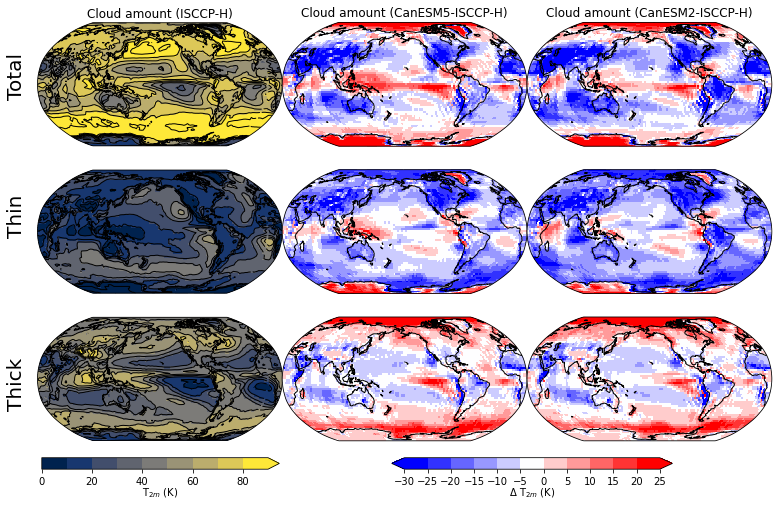

In [10]:
### Show all seasons
# Compute differences
canesm5_diff_total = ds_canesm5_climo['total_cld_amt'].to_numpy()-ds_isccp_h_climo['total_cld_amt'].to_numpy()
canesm5_diff_thick = ds_canesm5_climo['low_cld_amt'].to_numpy()-ds_isccp_h_climo['low_cld_amt'].to_numpy()
canesm5_diff_thin = ds_canesm5_climo['nonlow_cld_amt'].to_numpy()-ds_isccp_h_climo['nonlow_cld_amt'].to_numpy()

canesm2_diff_total = ds_canesm2_climo['total_cld_amt'].to_numpy()-ds_isccp_h_climo['total_cld_amt'].to_numpy()
canesm2_diff_thick = ds_canesm2_climo['low_cld_amt'].to_numpy()-ds_isccp_h_climo['low_cld_amt'].to_numpy()
canesm2_diff_thin = ds_canesm2_climo['nonlow_cld_amt'].to_numpy()-ds_isccp_h_climo['nonlow_cld_amt'].to_numpy()

# Layout the axes
fig = py.figure(constrained_layout=False,figsize=[12,8])
widths=[1,1,1]
heights=[1,1,1]
#gs1 = fig.add_gridspec(4,3,width_ratios=widths,height_ratios=heights,
#                       left=0.085,right=0.95,wspace=0.09,hspace=0.18)
gs1 = fig.add_gridspec(3,3,width_ratios=widths,height_ratios=heights,
                       left=0.07,right=0.92,bottom=0.125,wspace=0.0,
                       hspace=0.05)

f_ax1_1 = fig.add_subplot(gs1[0,0],projection=ccrs.Robinson(central_longitude=200))
f_ax1_2 = fig.add_subplot(gs1[0,1],projection=ccrs.Robinson(central_longitude=200))
f_ax1_3 = fig.add_subplot(gs1[0,2],projection=ccrs.Robinson(central_longitude=200))
f_ax2_1 = fig.add_subplot(gs1[1,0],projection=ccrs.Robinson(central_longitude=200))
f_ax2_2 = fig.add_subplot(gs1[1,1],projection=ccrs.Robinson(central_longitude=200))
f_ax2_3 = fig.add_subplot(gs1[1,2],projection=ccrs.Robinson(central_longitude=200))
f_ax3_1 = fig.add_subplot(gs1[2,0],projection=ccrs.Robinson(central_longitude=200))
f_ax3_2 = fig.add_subplot(gs1[2,1],projection=ccrs.Robinson(central_longitude=200))
f_ax3_3 = fig.add_subplot(gs1[2,2],projection=ccrs.Robinson(central_longitude=200))

cmap1 = py.get_cmap('cividis')
#cmap1 = py.get_cmap('gray_r')
#cmapt = cmocean.cm.thermal
#cmap1= ListedColormap(cmapt(np.linspace(0.2,1.0,128)))
levels1=np.arange(0,100,10)
norm1 = BoundaryNorm(levels1, ncolors=cmap1.N, clip=True)

cmap2 = py.get_cmap('bwr')
levels2=np.arange(-30,30,5)
#levels2=np.asarray([-4.75,-4.25,-3.75,-3.25,-2.75,-2.25,-1.75,-1.25,-0.75,-0.25,
#                   0.25,0.75,1.25,1.75,2.25,2.75,3.25,3.75,4.25,4.75])
#levels2_ticks=np.asarray([-4.25,-3.25,-2.25,-1.25,-0.25,0.25,1.25,2.25,3.25,4.25])
#levels2_ticklabels=np.asarray(['-4.25','-3.25','-2.25','-1.25','-0.25','0.25','1.25','2.25','3.25','4.25'])
levels2_ticks=levels2 #np.asarray([-4.75,-3.75,-2.75,-1.75,-0.75,0.75,1.75,2.75,3.75,4.75])
#levels2_ticklabels=np.asarray(['-4.75','-3.75','-2.75','-1.75','-0.75','0.75','1.75','2.75','3.75','4.75'])
norm2 = BoundaryNorm(levels2, ncolors=cmap2.N, clip=True)

obs_vmin=0
obs_vmax=80
anom_vmin=-30
anom_vmax=30

###################################
# Make the plots
###################################

# Plot the pr from ERA5

f1_1=f_ax1_1.pcolormesh(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['total_cld_amt'],
                        vmin=obs_vmin,vmax=obs_vmax,cmap=cmap1,norm=norm1,shading='auto',transform=ccrs.PlateCarree())
cs1_1=f_ax1_1.contour(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['total_cld_amt'], 
                      levels=levels1, colors='k',transform=ccrs.PlateCarree(), linewidths=1)
f_ax1_1.set_title("Cloud amount (ISCCP-H)")
f_ax1_1.coastlines()

f1_2=f_ax1_2.pcolormesh(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],canesm5_diff_total,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_2=f_ax1_2.contour(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['tas'].sel(season="DJF"), 
#                  levels=levels1, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
f_ax1_2.set_title("Cloud amount (CanESM5-ISCCP-H)")
f_ax1_2.coastlines()

f1_3=f_ax1_3.pcolormesh(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],canesm2_diff_total,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_3=f_ax1_3.contour(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['uas'], 10, colors='k',
#                  transform=ccrs.PlateCarree(), linewidths=1)
f_ax1_3.set_title("Cloud amount (CanESM2-ISCCP-H)")
f_ax1_3.coastlines()

f2_1=f_ax2_1.pcolormesh(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['low_cld_amt'],
                        vmin=obs_vmin,vmax=obs_vmax,cmap=cmap1,norm=norm1,shading='auto',transform=ccrs.PlateCarree())
cs2_1=f_ax2_1.contour(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['low_cld_amt'], 
                      levels=levels1, colors='k',transform=ccrs.PlateCarree(), linewidths=1)
f_ax2_1.coastlines()

f2_2=f_ax2_2.pcolormesh(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],canesm5_diff_thin,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_2=f_ax1_2.contour(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['tas'].sel(season="DJF"), 
#                  levels=levels1, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
f_ax2_2.coastlines()

f2_3=f_ax2_3.pcolormesh(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],canesm2_diff_thin,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_3=f_ax1_3.contour(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['uas'], 10, colors='k',
#                  transform=ccrs.PlateCarree(), linewidths=1)
f_ax2_3.coastlines()

f3_1=f_ax3_1.pcolormesh(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['nonlow_cld_amt'],
                        vmin=obs_vmin,vmax=obs_vmax,cmap=cmap1,norm=norm1,shading='auto',transform=ccrs.PlateCarree())
cs3_1=f_ax3_1.contour(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['nonlow_cld_amt'], 
                      levels=levels1, colors='k',transform=ccrs.PlateCarree(), linewidths=1)
f_ax3_1.coastlines()

f3_2=f_ax3_2.pcolormesh(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],canesm5_diff_thick,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_2=f_ax1_2.contour(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['tas'].sel(season="DJF"), 
#                  levels=levels1, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
f_ax3_2.coastlines()

f3_3=f_ax3_3.pcolormesh(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],canesm2_diff_thick,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_3=f_ax1_3.contour(ds_isccp_h_climo['lon'],ds_isccp_h_climo['lat'],ds_isccp_h_climo['uas'], 10, colors='k',
#                  transform=ccrs.PlateCarree(), linewidths=1)
f_ax3_3.coastlines()


# Add common colorbars
cax1 = py.axes([0.075, 0.09, 0.275, 0.02])
cb1=py.colorbar(f1_1,cax=cax1,orientation='horizontal',ticks=levels1[::2],extend='max')
cb1.set_label(r"T$_{2m}$ (K)",labelpad=-1)

cax2 = py.axes([0.48, 0.09, 0.325, 0.02])
cb2=py.colorbar(f1_2,cax=cax2,orientation='horizontal',ticks=levels2_ticks,extend='both')
#cax2.set_xticklabels(levels2_ticklabels)#,rotation=30)
cb2.set_label(r"$\Delta$ T$_{2m}$ (K)",labelpad=-1)

# Add text so it is clear what season is in each row
fig.text(0.035, 0.74, "Total", fontsize=20,rotation=90)
fig.text(0.035, 0.50, "Thin", fontsize=20,rotation=90)
#fig.text(0.055, 0.40, "JJA", fontsize=20,rotation=90)
fig.text(0.035, 0.20, "Thick", fontsize=20,rotation=90)

Text(30, -13, 'thick')

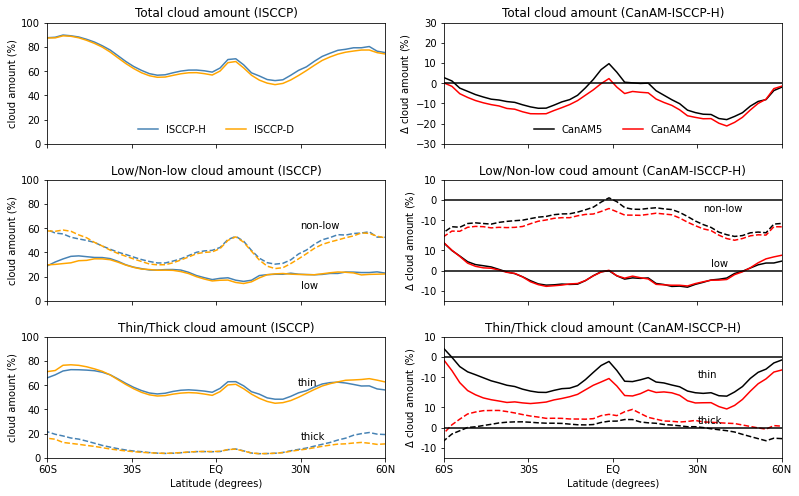

In [11]:
# Compute the zonal means and differences
ds_isccp_h_zonal = ds_isccp_h_climo.mean('lon')
ds_isccp_d_zonal = ds_isccp_d_climo.mean('lon')
ds_canesm5_zonal = ds_canesm5_climo.mean('lon')
ds_canesm2_zonal = ds_canesm2_climo.mean('lon')

canesm5_diff_total = ds_canesm5_zonal['total_cld_amt'].to_numpy()-ds_isccp_h_zonal['total_cld_amt'].to_numpy()
canesm5_diff_low = ds_canesm5_zonal['low_cld_amt'].to_numpy()-ds_isccp_h_zonal['low_cld_amt'].to_numpy()
canesm5_diff_nonlow = ds_canesm5_zonal['nonlow_cld_amt'].to_numpy()-ds_isccp_h_zonal['nonlow_cld_amt'].to_numpy()
canesm5_diff_thick = ds_canesm5_zonal['thick_cld_amt'].to_numpy()-ds_isccp_h_zonal['thick_cld_amt'].to_numpy()
canesm5_diff_thin = ds_canesm5_zonal['thin_cld_amt'].to_numpy()-ds_isccp_h_zonal['thin_cld_amt'].to_numpy()

canesm2_diff_total = ds_canesm2_zonal['total_cld_amt'].to_numpy()-ds_isccp_h_zonal['total_cld_amt'].to_numpy()
canesm2_diff_low = ds_canesm2_zonal['low_cld_amt'].to_numpy()-ds_isccp_h_zonal['low_cld_amt'].to_numpy()
canesm2_diff_nonlow = ds_canesm2_zonal['nonlow_cld_amt'].to_numpy()-ds_isccp_h_zonal['nonlow_cld_amt'].to_numpy()
canesm2_diff_thick = ds_canesm2_zonal['thick_cld_amt'].to_numpy()-ds_isccp_h_zonal['thick_cld_amt'].to_numpy()
canesm2_diff_thin = ds_canesm2_zonal['thin_cld_amt'].to_numpy()-ds_isccp_h_zonal['thin_cld_amt'].to_numpy()

# Layout the axes
fig = py.figure(constrained_layout=False,figsize=[12,8])
widths=[4,4]
heights=[1,1,1]
#gs1 = fig.add_gridspec(4,3,width_ratios=widths,height_ratios=heights,
#                       left=0.085,right=0.95,wspace=0.09,hspace=0.18)
gs1 = fig.add_gridspec(3,2,width_ratios=widths,height_ratios=heights,
                       left=0.07,right=0.92,bottom=0.125,wspace=0.175,
                       hspace=0.3)

f_ax1_1 = fig.add_subplot(gs1[0,0])
f_ax1_2 = fig.add_subplot(gs1[0,1])
f_ax2_1 = fig.add_subplot(gs1[1,0])
f_ax2_2 = fig.add_subplot(gs1[1,1])
f_ax3_1 = fig.add_subplot(gs1[2,0])
f_ax3_2 = fig.add_subplot(gs1[2,1])

lat=ds_isccp_h_clisccp.lat
###################################
# Make the plots
###################################

f1_1=f_ax1_1.plot(lat,ds_isccp_h_zonal.total_cld_amt,color='steelblue',linestyle="-",label="ISCCP-H")
f1_1=f_ax1_1.plot(lat,ds_isccp_d_zonal.total_cld_amt,color='orange',linestyle="-",label="ISCCP-D")
f_ax1_1.set_xlim(-60,60)
f_ax1_1.set_xticks([-60,-30,0,30,60])
f_ax1_1.set_xticklabels([])
f_ax1_1.set_ylim(0,100)
#f_ax1_1.set_yticks([])
#f_ax1_1.set_yticklabels([])
f_ax1_1.set_ylabel(r"cloud amount (%)")
f_ax1_1.set_title("Total cloud amount (ISCCP)")
f_ax1_1.legend(ncol=2,loc='lower center',frameon=False)

f1_2=f_ax1_2.plot(lat,canesm5_diff_total,'k-',label='CanAM5')
f1_2=f_ax1_2.plot(lat,canesm2_diff_total,'r-',label='CanAM4')
f_ax1_2.set_xlim(-60,60)
f_ax1_2.set_xticks([-60,-30,0,30,60])
f_ax1_2.set_xticklabels([])
f_ax1_2.set_ylim(-30,30)
#f_ax1_1.set_yticks([])
#f_ax1_1.set_yticklabels([])
f_ax1_2.set_ylabel(r"$\Delta$ cloud amount (%)")
f_ax1_2.axhline(0,color='k')
f_ax1_2.set_title("Total cloud amount (CanAM-ISCCP-H)")
f_ax1_2.legend(ncol=2,loc='lower center',frameon=False)

f2_1=f_ax2_1.plot(lat,ds_isccp_h_zonal.low_cld_amt,color='steelblue',linestyle="-")
f2_1=f_ax2_1.plot(lat,ds_isccp_h_zonal.nonlow_cld_amt,color='steelblue',linestyle="--")
f2_1=f_ax2_1.plot(lat,ds_isccp_d_zonal.low_cld_amt,color='orange',linestyle="-")
f2_1=f_ax2_1.plot(lat,ds_isccp_d_zonal.nonlow_cld_amt,color='orange',linestyle="--")
f_ax2_1.set_xlim(-60,60)
f_ax2_1.set_xticks([-60,-30,0,30,60])
f_ax2_1.set_xticklabels([])
f_ax2_1.set_ylim(0,100)
#f_ax2_1.set_yticks([])
#f_ax2_1.set_yticklabels([])
f_ax2_1.set_ylabel(r"cloud amount (%)")
f_ax2_1.set_title("Low/Non-low cloud amount (ISCCP)")
f_ax2_1.text(30,60,'non-low')
f_ax2_1.text(30,10,'low')

f2_2=f_ax2_2.plot(lat,canesm5_diff_low-15,'k',linestyle="-")
f2_2=f_ax2_2.plot(lat,canesm5_diff_nonlow+20,'k',linestyle="--")
f2_2=f_ax2_2.plot(lat,canesm2_diff_low-15,'r',linestyle="-")
f2_2=f_ax2_2.plot(lat,canesm2_diff_nonlow+20,'r',linestyle="--")
f_ax2_2.set_xlim(-60,60)
f_ax2_2.set_xticks([-60,-30,0,30,60])
f_ax2_2.set_xticklabels([])
f_ax2_2.set_ylim(-30,30)
f_ax2_2.set_yticks([-25,-15,-5,10,20,30])
f_ax2_2.set_yticklabels(['-10','0','10','-10','0','10'])
f_ax2_2.set_ylabel(r"$\Delta$ cloud amount (%)")
f_ax2_2.axhline(-15,color='k')
f_ax2_2.axhline(20,color='k')
f_ax2_2.set_title("Low/Non-low coud amount (CanAM-ISCCP-H)")
f_ax2_2.text(32,14,'non-low',color='k')
f_ax2_2.text(35,-13,'low',color='k')

f3_1=f_ax3_1.plot(lat,ds_isccp_h_zonal.thin_cld_amt,color='steelblue',linestyle="-")
f3_1=f_ax3_1.plot(lat,ds_isccp_h_zonal.thick_cld_amt,color='steelblue',linestyle="--")
f3_1=f_ax3_1.plot(lat,ds_isccp_d_zonal.thin_cld_amt,color='orange',linestyle="-")
f3_1=f_ax3_1.plot(lat,ds_isccp_d_zonal.thick_cld_amt,color='orange',linestyle="--")
f_ax3_1.set_xlim(-60,60)
f_ax3_1.set_xticks([-60,-30,0,30,60])
f_ax3_1.set_xticklabels(['60S','30S','EQ','30N','60N'])
f_ax3_1.set_xlabel('Latitude (degrees)')
f_ax3_1.set_ylim(0,100)
#f_ax3_1.set_yticks([])
#f_ax3_1.set_yticklabels([])
f_ax3_1.set_ylabel(r"cloud amount (%)")
f_ax3_1.set_title("Thin/Thick cloud amount (ISCCP)")
f_ax3_1.text(29,60,'thin')
f_ax3_1.text(30,15,'thick')

f3_2=f_ax3_2.plot(lat,canesm5_diff_thin+20,'k',linestyle="-")
f3_2=f_ax3_2.plot(lat,canesm2_diff_thin+20,'r',linestyle="-")
f_ax3_2.plot(lat,canesm5_diff_thick-15,'k',linestyle="--")
f_ax3_2.plot(lat,canesm2_diff_thick-15,'r',linestyle="--")
f_ax3_2.set_xlim(-60,60)
f_ax3_2.set_xticks([-60,-30,0,30,60])
f_ax3_2.set_xticklabels(['60S','30S','EQ','30N','60N'])
f_ax3_2.set_xlabel('Latitude (degrees)')
f_ax3_2.set_ylim(-30,30)
f_ax3_2.set_yticks([-25,-15,-5,10,20,30])
f_ax3_2.set_yticklabels(['-10','0','10','-10','0','10'])
f_ax3_2.set_ylabel(r"$\Delta$ cloud amount (%)")
f_ax3_2.axhline(20,color='k')
f_ax3_2.axhline(-15,color='k')
f_ax3_2.set_title("Thin/Thick cloud amount (CanAM-ISCCP-H)")
f_ax3_2.text(30,10,'thin',color='k')
f_ax3_2.text(30,-13,'thick',color='k')